# MTS Gold Price

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px # type: ignore

In [2]:
import sys
sys.path.append('..')

In [3]:
from utils.plot import plot_time_series
from utils.preds import evaluate_preds

## Fetch Data

In [4]:
dirname = os.path.join(os.getcwd(), '..', 'data', 'Gold_Price.csv')

In [5]:
gold_price = pd.read_csv(dirname, header=0, index_col=0)
gold_price.head()

,Price,Open,High,Low,Volume,Chg%
Date,,,,,,
2025-01-06,77149,77309,77542,76545,27160,0.44
2025-01-03,76813,77246,78600,76613,60,-0.05
2025-01-02,76849,76849,76849,76849,0,0.83
2025-01-01,76214,76232,76302,76053,60,-0.02
2024-12-31,76232,75680,76970,75572,1920,0.95


## Clean the Data

In [6]:
gold_price.shape

(2848, 6)

In [7]:
# Check out if there is some NA in our dataframe
gold_price.isna().any().any()

False

In [8]:
# Let's conver the index into datetime
gold_price.index = pd.to_datetime(gold_price.index)
isinstance(gold_price.index, pd.DatetimeIndex)

True

We have to reverse the order of the index, i.e, the first date we see must be the last one in the pd.DataFrame as so on.

In [9]:
gold_price = gold_price.sort_index(ascending=True)
gold_price.head(5)

,Price,Open,High,Low,Volume,Chg%
Date,,,,,,
2014-01-01,29542,29435,29598,29340,2930,0.25
2014-01-02,29975,29678,30050,29678,3140,1.47
2014-01-03,29727,30031,30125,29539,3050,-0.83
2014-01-04,29279,29279,29279,29279,0,-1.51
2014-01-06,29119,29300,29395,29051,24380,-0.55


In [10]:
# Let's check which days are missing from a given year
year = 2023
all_days = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31', freq='D')
existing_days = gold_price.loc[str(year)].index.normalize() # remove the hours
missing_days = all_days.difference(existing_days)

print(f'Total number of days in {year}: {len(all_days)}')
print(f'Number of existing days in the Gold Price dataset in {year}: {len(existing_days)}')
print(f'Number of missing days in the Gold Price dataset in {year}: {len(missing_days)}')

Total number of days in 2023: 365
Number of existing days in the Gold Price dataset in 2023: 256
Number of missing days in the Gold Price dataset in 2023: 109


In [11]:
missing_weekends = missing_days[missing_days.weekday >= 5]
missing_non_weekends = missing_days[missing_days.weekday < 5]

print(f'Number of Weekend Days in {year}: {len(missing_weekends)}')
print(f'Number of Non Weekend Days in {year}: {len(missing_non_weekends)}')

Number of Weekend Days in 2023: 104
Number of Non Weekend Days in 2023: 5


The gold market does not operate on holidays or weekends.

We could fill the gaps with the technique `ffill()`, which fill with the last known value. This one is a good approach in this case, because the value doesn't change when the market is closed.

In [12]:
gold_price = gold_price.reindex(pd.date_range(gold_price.index.min(), gold_price.index.max(), freq='D'))
cols_ffill = gold_price.columns.difference(['Chg%', 'Volume'])
gold_price[cols_ffill] = gold_price[cols_ffill].ffill()
gold_price['Chg%'] = gold_price['Chg%'].fillna(0.0)
gold_price['Volume'] = gold_price['Volume'].fillna(0.0)
gold_price.head(10)

,Price,Open,High,Low,Volume,Chg%
2014-01-01,29542.0,29435.0,29598.0,29340.0,2930.0,0.25
2014-01-02,29975.0,29678.0,30050.0,29678.0,3140.0,1.47
2014-01-03,29727.0,30031.0,30125.0,29539.0,3050.0,-0.83
2014-01-04,29279.0,29279.0,29279.0,29279.0,0.0,-1.51
2014-01-05,29279.0,29279.0,29279.0,29279.0,0.0,0.00
2014-01-06,29119.0,29300.0,29395.0,29051.0,24380.0,-0.55
2014-01-07,28959.0,29130.0,29195.0,28912.0,18710.0,-0.55
2014-01-08,28934.0,28916.0,29029.0,28820.0,18140.0,-0.09
2014-01-09,28997.0,28990.0,29053.0,28865.0,15130.0,0.22
2014-01-10,29169.0,29030.0,29198.0,28960.0,15810.0,0.59


## Visualize the Gold Price and some simple statistics

In [13]:
# First date and Last date
gold_price.index.min(), gold_price.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

In [14]:
# Min value, Max value
gold_price.Price.min(), gold_price.Price.max()

(24545.0, 79257.0)

In [15]:
fig = px.line(gold_price, x=gold_price.index, y='Price', title='Evolution of the Gold Price through Time')
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Gold Price (USD)'
)
fig.show()

## Decompose the Serie

Let's check whether our time serie is additive or multiplicative.

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

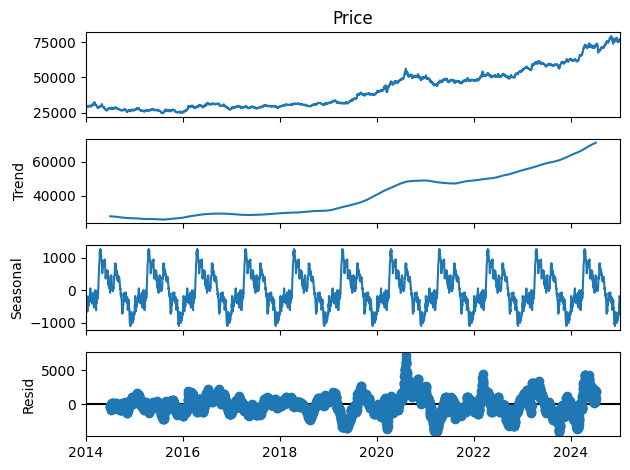

In [17]:
decompose_plot_additive = seasonal_decompose(gold_price.Price, model='additive', period=365)
decompose_plot_additive.plot()
plt.show()

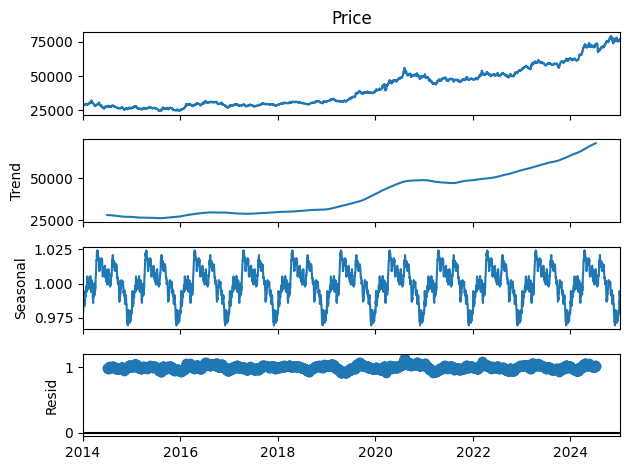

In [18]:
decompose_plot_multiplicative = seasonal_decompose(gold_price.Price, model='multiplicative', period=365)
decompose_plot_multiplicative.plot()
plt.show()

We can see that is multiplicative by the residuals, in the additive models they grow up with the time.

So, we will have to apply `log` to our serie in a future.

## Feature Engineering

In [19]:
import holidays

In [20]:
start_year = gold_price.index.min().year
end_year = gold_price.index.max().year

us_holidays = holidays.UnitedStates(years=range(start_year, end_year + 1))
uk_holidays = holidays.UnitedKingdom(years=range(start_year, end_year + 1))

combined = set(us_holidays.keys()) | set(uk_holidays.keys())

idx_dates = gold_price.index.normalize().date
gold_price["is_holiday"] = [1 if d in combined else 0 for d in idx_dates]

holiday_list = sorted(list(combined))

def days_to_next(date_val: pd.Timestamp) -> int:
    for h in holiday_list:
        if h >= date_val:
            return (h - date_val).days
    return np.nan
    
gold_price['days_to_next_holiday'] = [days_to_next(d) for d in idx_dates]

gold_price.loc[:, "is_weekend"] = (gold_price.index.weekday >= 5).astype(int)

gold_price.head(10)

,Price,Open,High,Low,Volume,Chg%,is_holiday,days_to_next_holiday,is_weekend
2014-01-01,29542.0,29435.0,29598.0,29340.0,2930.0,0.25,1,0,0
2014-01-02,29975.0,29678.0,30050.0,29678.0,3140.0,1.47,0,18,0
2014-01-03,29727.0,30031.0,30125.0,29539.0,3050.0,-0.83,0,17,0
2014-01-04,29279.0,29279.0,29279.0,29279.0,0.0,-1.51,0,16,1
2014-01-05,29279.0,29279.0,29279.0,29279.0,0.0,0.00,0,15,1
2014-01-06,29119.0,29300.0,29395.0,29051.0,24380.0,-0.55,0,14,0
2014-01-07,28959.0,29130.0,29195.0,28912.0,18710.0,-0.55,0,13,0
2014-01-08,28934.0,28916.0,29029.0,28820.0,18140.0,-0.09,0,12,0
2014-01-09,28997.0,28990.0,29053.0,28865.0,15130.0,0.22,0,11,0
2014-01-10,29169.0,29030.0,29198.0,28960.0,15810.0,0.59,0,10,0


In [21]:
gold_price.index.min(), gold_price.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

## Create train and test sets for time series

In [22]:
timesteps = gold_price.index.to_numpy()
price = gold_price.Price.to_numpy()

In [23]:
# Create train and test splits, 80% train, 20% test
split_size = int(0.8 * len(price))

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], price[:split_size]

# Create test data splits (everything beyond the split)
X_test, y_test = timesteps[split_size:], price[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(3219, 3219, 805, 805)

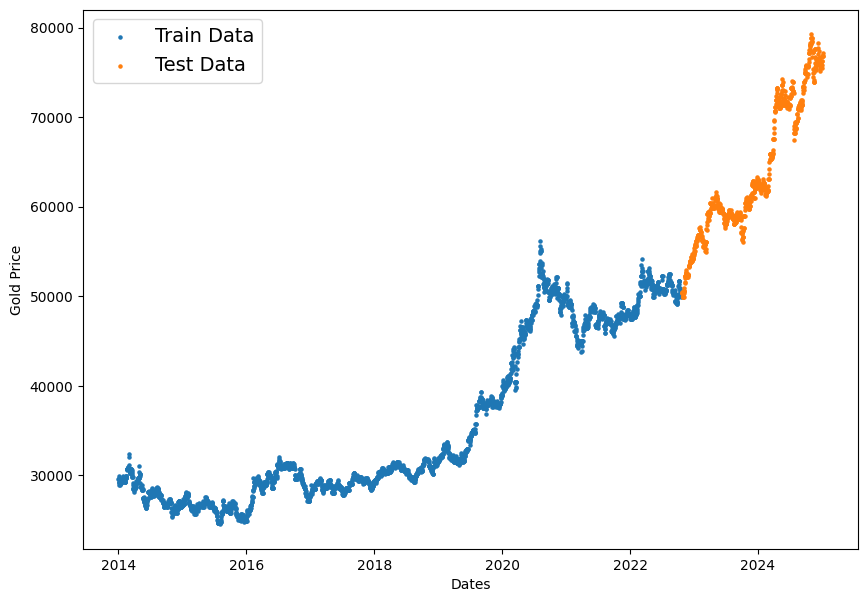

In [24]:
# Plot with train and test
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label='Train Data')
plt.scatter(X_test, y_test, s=5, label='Test Data')
plt.xlabel('Dates')
plt.ylabel('Gold Price')
plt.legend(fontsize=14)
plt.show()

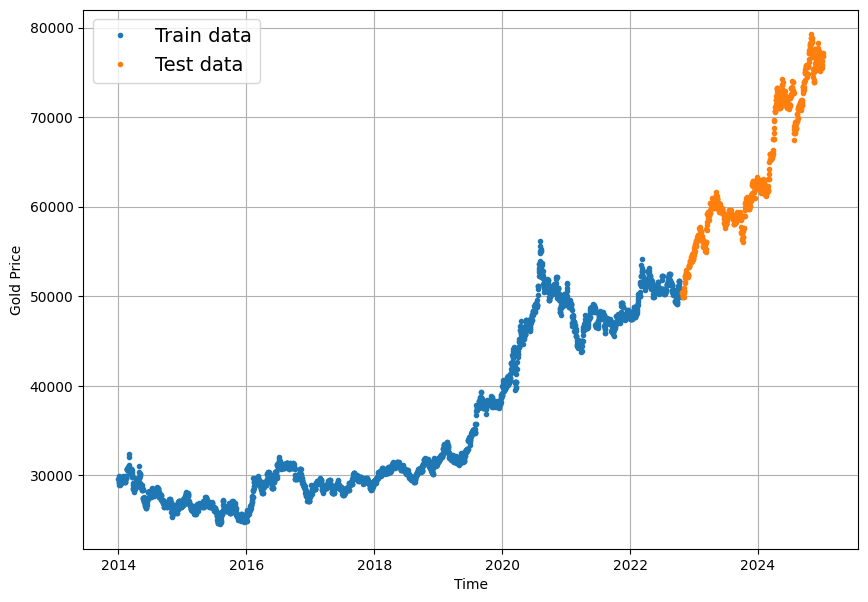

In [25]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data", xlabel='Time', ylabel='Gold Price')
plot_time_series(timesteps=X_test, values=y_test, label="Test data", xlabel='Time', ylabel='Gold Price')

## Baselines Models

### Baseline 0: Naive Forecast

$$\hat{y}_{t+1} = y_t$$

In [26]:
# Create a naive forecast
naive_preds = y_test[:-1]
naive_preds[:5]

array([50353., 50411., 50450., 49956., 49956.])

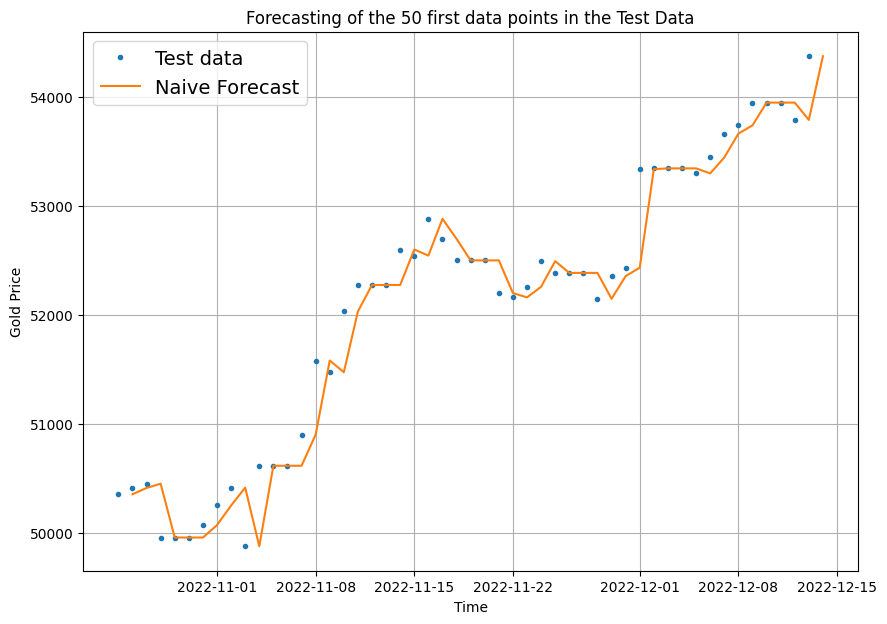

In [27]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Test data", start=0, end=50)
plot_time_series(timesteps=X_test[1:], values=naive_preds, format='-', label='Naive Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=50)
plt.title('Forecasting of the 50 first data points in the Test Data')
plt.show()

In [28]:
naive_metrics = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_preds)
naive_metrics

{'mae': 233.07214, 'mse': 163311.62, 'rmse': 404.11835, 'mape': 0.3581797}

### Baseline 1: ARIMA

Bibliography: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

* **AR (Autoregression):** This emphasizes the dependent relationship between an observation and its preceding or 'lagged' observations.
* **I (Integrated):** To achieve a stationary time series, one that doesn't exhibit trend or seasonality, differencing is applied. It typically involves subtracting an observation from its preceding observation.
* **MA (Moving Average):** This component zeroes in on the relationship between an observation and the residual error from a moving average model based on lagged observations.

In [29]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.gofplots import qqplot

#### Stationarity

We first need to apply logarithms to the serie, because we saw that it was a multiplicative model.

In [30]:
log_gold_price = np.log(gold_price.Price)
log_gold_price.head()

2014-01-01    10.293568
2014-01-02    10.308119
2014-01-03    10.299811
2014-01-04    10.284626
2014-01-05    10.284626
Freq: D, Name: Price, dtype: float64

In [31]:
# Check for stationarity (mean and variance constant)
adf = adfuller(log_gold_price)
print(f'ADF p-value: {adf[1]}')

ADF p-value: 0.9911734545221277


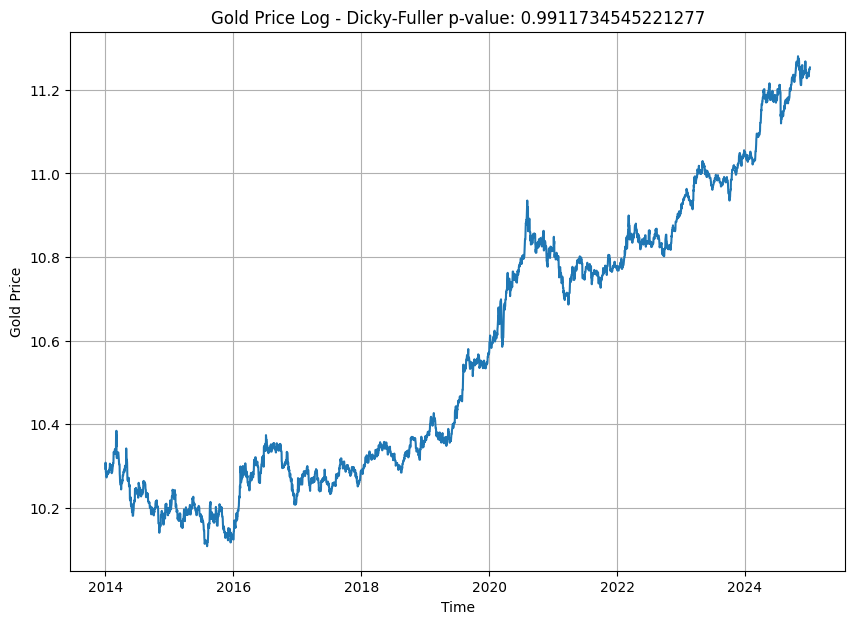

In [32]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=log_gold_price.index,
                 values=log_gold_price.values,
                 format='-',
                 xlabel='Time',
                 ylabel='Gold Price')
plt.title(f'Gold Price Log - Dicky-Fuller p-value: {adf[1]}')
plt.show()

In [33]:
# We have to differentiate, because the p-value was greater than 0.05
log_gold_price_stationarity = log_gold_price.diff().dropna()
adf_diff = adfuller(log_gold_price_stationarity)
print(f'ADF p-value with 1 differentation: {adf_diff[1]}')

ADF p-value with 1 differentation: 2.8469869896195193e-30


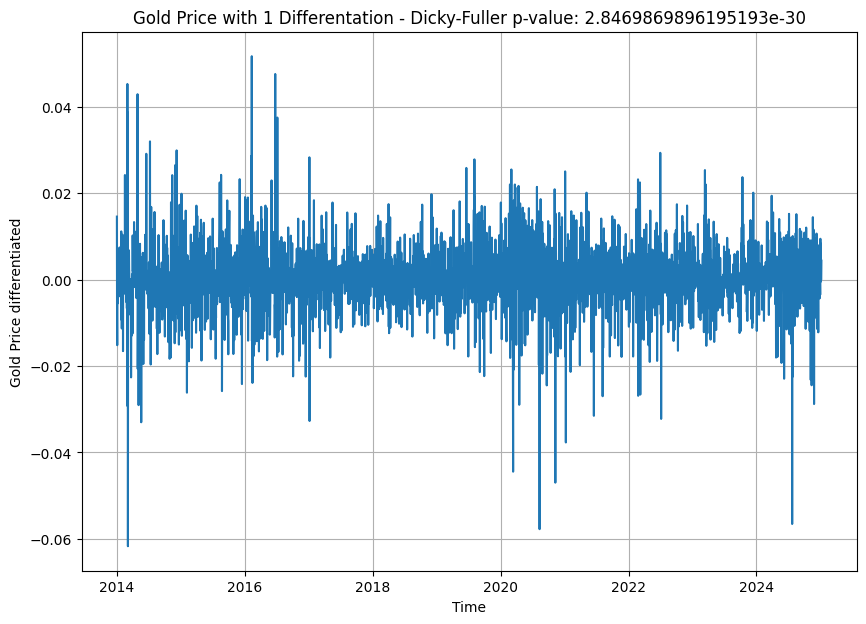

In [34]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=log_gold_price_stationarity.index,
                 values=log_gold_price_stationarity.values,
                 format='-',
                 xlabel='Time',
                 ylabel='Gold Price differentiated')
plt.title(f'Gold Price with 1 Differentation - Dicky-Fuller p-value: {adf_diff[1]}')
plt.show()

#### ACF and PACF

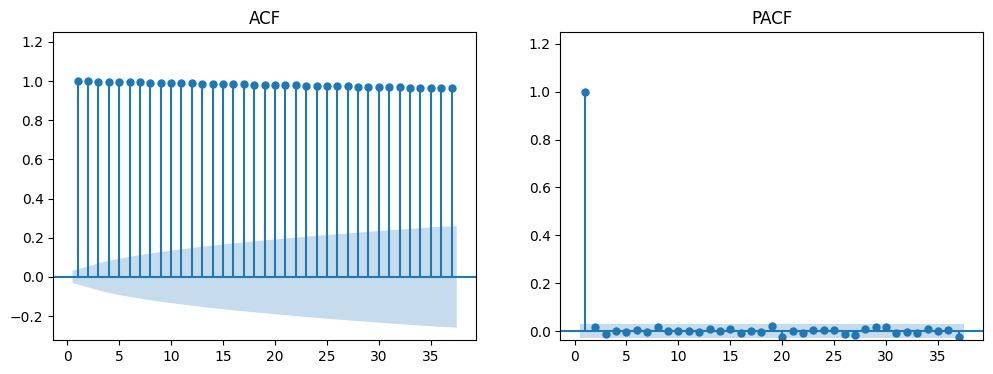

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(gold_price.Price, ax=axes[0], zero=False, auto_ylims=True, title='ACF')
plot_pacf(gold_price.Price, ax=axes[1], zero=False, auto_ylims=True, title='PACF')
plt.show()

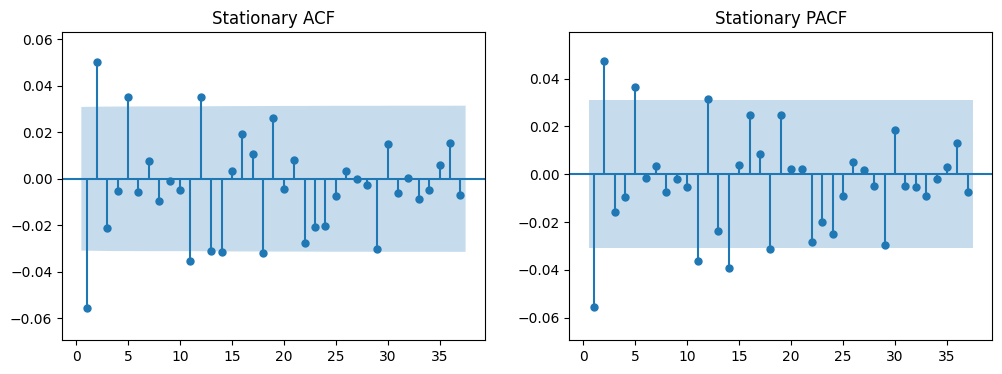

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(log_gold_price_stationarity, ax=axes[0], zero=False, auto_ylims=True, title='Stationary ACF')
plot_pacf(log_gold_price_stationarity, ax=axes[1], zero=False, auto_ylims=True, title='Stationary PACF')
plt.show()

We can try the next models:

* `ARIMA(0, 1, 0)` - **Random Walk**
* `ARIMA(1, 1, 0)`
* `ARIMA(1, 1, 1)`
* `ARIMA(1, 1, 2)`

#### Create Model

In [37]:
log_gold_price_train = pd.Series(np.log(y_train), index=pd.DatetimeIndex(X_train, freq='D'))
log_gold_price_test = pd.Series(np.log(y_test), index=pd.DatetimeIndex(X_test, freq='D'))

In [38]:
model_arima_010 = ARIMA(log_gold_price_train, order=(0, 1, 0))
model_arima_110 = ARIMA(log_gold_price_train, order=(1, 1, 0))
model_arima_111 = ARIMA(log_gold_price_train, order=(1, 1, 1))
model_arima_112 = ARIMA(log_gold_price_train, order=(1, 1, 2))

results_arima_010 = model_arima_010.fit() # the warning below is because this line
results_arima_110 = model_arima_110.fit()
results_arima_111 = model_arima_111.fit()
results_arima_112 = model_arima_112.fit()

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [39]:
results_arima_010.summary(), results_arima_110.summary(), results_arima_111.summary(), results_arima_112.summary()

(<class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                      y   No. Observations:                 3219
 Model:                 ARIMA(0, 1, 0)   Log Likelihood               11306.440
 Date:                Tue, 09 Sep 2025   AIC                         -22610.880
 Time:                        18:30:57   BIC                         -22604.803
 Sample:                    01-01-2014   HQIC                        -22608.702
                          - 10-24-2022                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 sigma2      5.195e-05   5.61e-07     92.596      0.000    5.09e-05    5.31e-05
 Ljung-Box (L1) (Q):                  13.12   Jarque-Bera (JB):       

The best ARIMA model looking at the AIC metric is: `ARIMA(1, 1, 2)`.

Now, we will make the predictions using the **walk-forward** technique.

In [40]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

In [41]:
history = list(log_gold_price_train)
arima_preds = []
for obs in log_gold_price_test:
    model = ARIMA(history, order=(1, 1, 2))
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=ConvergenceWarning)
        results = model.fit()
    log_pred = results.forecast()[0]
    arima_preds.append(np.exp(log_pred))
    history.append(obs) # take in the real observation

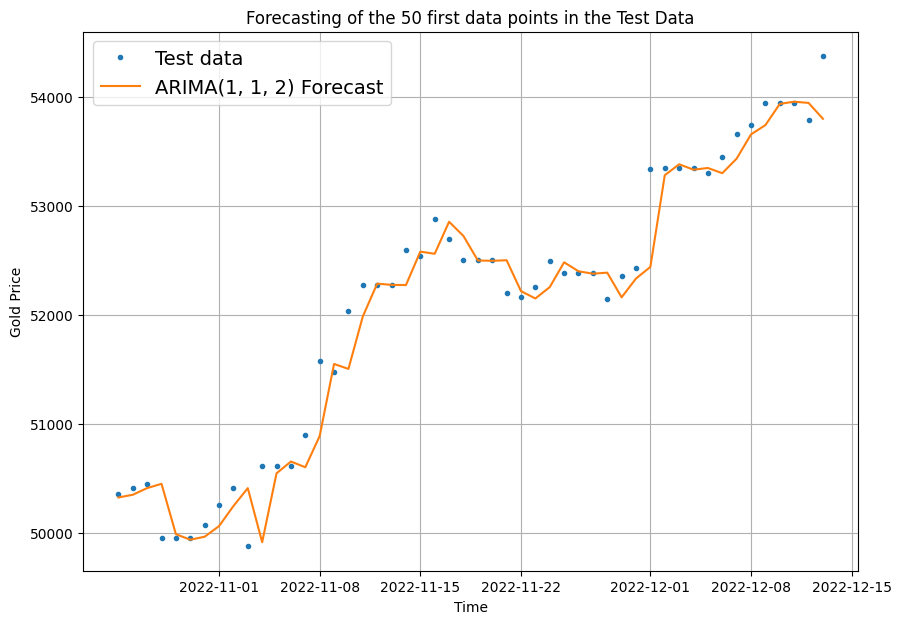

In [42]:
# Plot ARIMA(1, 1, 0) forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Test data", start=0, end=50)
plot_time_series(timesteps=X_test, values=arima_preds, format='-', label='ARIMA(1, 1, 2) Forecast', xlabel='Time', ylabel='Gold Price', start=0, end=50)
plt.title('Forecasting of the 50 first data points in the Test Data')
plt.show()

In [43]:
arima_metrics = evaluate_preds(y_true=y_test,
                               y_pred=arima_preds)
arima_metrics

{'mae': 239.4, 'mse': 162393.67, 'rmse': 402.981, 'mape': 0.36796907}

### Baseline 2: SARIMAX

Our TS is anual stational, so we would need to look at the lags 365, 730 and so on, if we want to know the parameters P and Q of the model ``SARIMAX(p, d, q)x(P, D, Q, m)``. Therefore, we will use grid search to compute the best parameters. We will try the next models:

* ``SARIMAX(0, 1, 0)x(0, 1, 0, 365)``
* ``SARIMAX(1, 1, 0)x(0, 1, 0, 365)``
* ``SARIMAX(1, 1, 0)x(1, 1, 0, 365)``
* ``SARIMAX(1, 1, 0)x(0, 1, 1, 365)``
* ``SARIMAX(1, 1, 0)x(1, 1, 1, 365)``
* ``SARIMAX(1, 1, 0)x(2, 1, 0, 365)``
* ``SARIMAX(1, 1, 0)x(0, 1, 2, 365)``
* ``SARIMAX(1, 1, 0)x(2, 1, 1, 365)``
* ``SARIMAX(1, 1, 0)x(1, 1, 2, 365)``

In [44]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

#### Exogenus variables

First of all, we have to load, clean, transform and put all the exogenus variables into the `gold_price` dataframe.

In [ ]:
from utils.load import load_csv_into_dates, load_csv_and_glue_time_series

In [46]:
folder_exogenus_gold_variables = os.path.join(os.getcwd(), '..', 'data', 'exogenus_gold')

##### BRENT

In [47]:
brent = load_csv_into_dates(dirname=os.path.join(folder_exogenus_gold_variables, 'brent', 'brent-daily.csv'))
brent.index.min(), brent.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

##### WTI

In [48]:
wti = load_csv_into_dates(dirname=os.path.join(folder_exogenus_gold_variables, 'wti', 'wti-daily.csv'))
wti.index.min(), wti.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

##### DXY - Dollar Index

In [55]:
folder_dxy = os.path.join(folder_exogenus_gold_variables, 'DXY')
dxy = load_csv_and_glue_time_series(folder_path=folder_dxy, column_name='Open')
dxy.index.min(), dxy.index.max()

c:\Users\Usuario\Documents\Time_Series_Comparision_Models\analysis\..\utils\load.py:11: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



(Timestamp('2014-01-01 00:00:00'), Timestamp('2025-01-06 00:00:00'))

##### ~~EURUSD~~

In [66]:
eurusd = pd.read_csv(os.path.join(os.getcwd(), '..', 'data', 'exogenus_gold', 'CURRENCY_US_XTUP_EURUSD.csv'), header=0, index_col=0)
eurusd.index = pd.to_datetime(eurusd.index)

eurusd = eurusd.loc[:, 'Open']
eurusd = eurusd.reindex(pd.date_range(start=eurusd.index.min(), end=eurusd.index.max(), freq='D')).ffill()

eurusd_2014_2025 = eurusd.loc['2014-01-01':'2025-01-06']
eurusd_2014_2025.index.min(), eurusd_2014_2025.index.max()

(Timestamp('2024-01-08 00:00:00'), Timestamp('2025-01-06 00:00:00'))

##### ~~VIX~~

In [69]:
vix = pd.read_csv(os.path.join(os.getcwd(), '..', 'data', 'exogenus_gold', 'INDEX_US_CBSX_VIX.csv'), header=0, index_col=0)
vix.index = pd.to_datetime(vix.index)

vix = vix.loc[:, 'Open']
vix = vix.reindex(pd.date_range(start=vix.index.min(), end=vix.index.max(), freq='D')).ffill()

vix_2014_2025 = vix.loc['2014-01-01':'2025-01-06']
vix_2014_2025.index.min(), vix_2014_2025.index.max()

(Timestamp('2024-01-08 00:00:00'), Timestamp('2025-01-06 00:00:00'))

We need to separate our exogenus variables from our raw gold_price dataframe. Furthermore, we will need also to split in train and test this new dataset.

In [56]:
exog_data = gold_price.reset_index().drop(columns=['index', 'Price'])
exog_data.head()

,Open,High,Low,Volume,Chg%,is_weekend
0,29435.0,29598.0,29340.0,2930.0,0.25,False
1,29678.0,30050.0,29678.0,3140.0,1.47,False
2,30031.0,30125.0,29539.0,3050.0,-0.83,False
3,29279.0,29279.0,29279.0,0.0,-1.51,True
4,29279.0,29279.0,29279.0,0.0,0.00,True


In [61]:
exog_train = exog_data.iloc[:split_size, :]
exog_test = exog_data.iloc[split_size:, :]

exog_train.shape, exog_test.shape

((3219, 6), (805, 6))

We also need to transform our 'anual seasonality' in terms of **Fourier** for agilize the computation, and get rid of the seasonality in SARIMAX.

In [73]:
from pmdarima.preprocessing import FourierFeaturizer

In [78]:
fourier_gen = FourierFeaturizer(m=365.25, k=4)
log_gold_price_fourier, exog_data_fourier = fourier_gen.fit_transform(log_gold_price.values, exog_data)

exog_train_fourier = exog_data_fourier.iloc[:split_size, :]
exog_test_fourier = exog_data_fourier.iloc[split_size:, :]

exog_train_fourier.shape, exog_test_fourier.shape

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



((3219, 14), (805, 14))

#### Create Model

In [83]:
model_sarimax_010_000_365 = SARIMAX(log_gold_price_train.values,
                                    exog=exog_train, order=(0, 1, 0), seasonal_order=(0, 0, 0, 0))
model_sarimax_110_000_365 = SARIMAX(log_gold_price_train.values,
                                    exog=exog_train, order=(1, 1, 0), seasonal_order=(0, 0, 0, 0))
model_sarimax_111_000_365 = SARIMAX(log_gold_price_train.values,
                                    exog=exog_train, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
model_sarimax_112_000_365 = SARIMAX(log_gold_price_train.values,
                                    exog=exog_train, order=(1, 1, 2), seasonal_order=(0, 0, 0, 0))

results_sarimax_010_000_365 = model_sarimax_010_000_365.fit()
results_sarimax_110_000_365 = model_sarimax_110_000_365.fit()
results_sarimax_111_000_365 = model_sarimax_111_000_365.fit()
results_sarimax_112_000_365 = model_sarimax_112_000_365.fit()

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Usuario\anaconda3\envs\ts\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [84]:
results_sarimax_010_000_365.summary(), results_sarimax_110_000_365.summary(), results_sarimax_111_000_365.summary(), results_sarimax_112_000_365.summary()

(<class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                      y   No. Observations:                 3219
 Model:               SARIMAX(0, 1, 0)   Log Likelihood                2570.737
 Date:               do., 07 sep. 2025   AIC                          -5127.474
 Time:                        00:02:26   BIC                          -5084.938
 Sample:                             0   HQIC                         -5112.229
                                - 3219                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 Open       -3.325e-06      0.001     -0.006      0.995      -0.001       0.001
 High        9.505e-06      0.000      0.020      0.984      -0.001   

The model with lowest AIC is `SARIMAX(1, 1, 2)x(0, 0, 0, 365)`, and is better than `ARIMA(1, 1, 2)`.